In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly
#import json

import glob


import gzip

from datetime import datetime



In [20]:


## POINTS
# https://www.mapillary.com/developer/api-documentation/points?locale=de_DE

# --- 1) Markierungen-Definitionen  --------------------------------
cw_marking = "marking--discrete--symbol--bicycle"  # Fahrradmarkierung


# --- 2) Load Mapillary map feature points data from parquet files  --------------------------------
# Find all parquet files in the output folder (per state)
parquet_files = glob.glob("../../output/mapillary_map-feature-points_*.parquet")
# Read all files and concatenate into one GeoDataFrame
mapillary_mf_points = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)


# Extract and print the dates from the filenames
dates = [f.split("_")[-1].replace(".parquet", "") for f in parquet_files]
# Drop all duplicates in the list
dates = list(set(dates))
print("Dates found in filenames:", dates)


# --- 3) Filter for relevant markings  --------------------------------
# filter for relevant markings
mapillary_mf_points_cw = mapillary_mf_points[mapillary_mf_points.value.isin([cw_marking])]

# cleanup
mapillary_mf_points_cw = mapillary_mf_points_cw.drop_duplicates(subset=['id'])


mapillary_mf_points_cw


Dates found in filenames: ['2025-11-16']


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
92,POINT (13.11844 52.51132),2025-07-04,1192415705981631,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
191,POINT (13.11838 52.51142),2025-07-04,754181033839454,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
212,POINT (13.11848 52.51128),2025-07-04,1192415672648301,2025-07-04,marking--discrete--symbol--bicycle,8789,5373
384,POINT (13.1013 52.41389),2016-03-25,906821999886958,2016-03-25,marking--discrete--symbol--bicycle,8788,5381
393,POINT (13.11042 52.41413),2024-05-09,1196164411795324,2024-05-09,marking--discrete--symbol--bicycle,8788,5381
...,...,...,...,...,...,...,...
34093348,POINT (9.44338 51.83199),2022-04-12,1141492059960306,2022-04-12,marking--discrete--symbol--bicycle,8621,5424
34093365,POINT (9.44324 51.83205),2020-09-03,181691620518405,2020-09-03,marking--discrete--symbol--bicycle,8621,5424
34093685,POINT (9.44066 51.83462),2020-09-03,3822412344652704,2020-09-03,marking--discrete--symbol--bicycle,8621,5424
34093757,POINT (9.44438 51.83118),2022-04-12,1141492053293640,2022-04-12,marking--discrete--symbol--bicycle,8621,5424


## Verarbeitung fuer export fuer radinfra.de

In [50]:
### zeitlicher Filter: only signs seen after 2023-01-01

mapillary_mf_points_cw=mapillary_mf_points_cw[mapillary_mf_points_cw["last_seen_at"] > "2023-01-01"].copy()

mapillary_mf_points_cw=mapillary_mf_points_cw[mapillary_mf_points_cw["first_seen_at"] > "2000-01-01"].copy()


len(mapillary_mf_points_cw)

25073

In [51]:
### cehck if really inside germany
import gzip
import json

gz_path = "../utils/OSMB-germany.geojson.gz"

# Try GDAL's virtual filesystem (/vsigzip) via pyogrio engine first
try:
    germany_boundary = gpd.read_file(f"/vsigzip/{gz_path}", engine="pyogrio")
except Exception:
    # Fallback: manual gzip decompress + GeoJSON parse
    with gzip.open(gz_path, "rt", encoding="utf-8") as f:
        geojson_obj = json.load(f)
    germany_boundary = gpd.GeoDataFrame.from_features(geojson_obj, crs="EPSG:4326")

In [52]:
# Clip traffic signs to Germany boundary

mapillary_mf_points_cw = gpd.sjoin(
    mapillary_mf_points_cw, 
    germany_boundary[['geometry']], 
    predicate='within', 
    how='inner'
)
mapillary_mf_points_cw = mapillary_mf_points_cw.drop(columns=['index_right'])

print(f"Traffic signs after clipping to Germany: {len(mapillary_mf_points_cw)}")

Traffic signs after clipping to Germany: 25073


In [53]:
### räumlicher Filter (Alle Traffic sign an Autobahnen raus, wg vielen falsch-positiven dort)

In [54]:
# ## parse autobahnen
# set_date = "251115" 
# motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

# ## now create a buffer around the traffic signs to check if there is a cycleway nearby
# mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw.to_crs(25833).copy()
# mapillary_trafficsigns_cw_buffered_30["geometry"] = mapillary_trafficsigns_cw_buffered_30.geometry.buffer(30)
# mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw_buffered_30.to_crs(mapillary_trafficsigns_cw.crs)


In [55]:
# # helper 
# def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
#     """
#     Marks which geometries in `buffered_df` intersect with `target_layer`.

#     Parameters:
#     - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
#     - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
#     - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

#     Returns:
#     - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
#     """
#     # Ensure CRS matches
#     buffered_df = buffered_df.to_crs(target_layer.crs)

#     # Perform spatial join to find intersecting geometries
#     joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

#     # Initialize the new column to False
#     buffered_df[column_name] = False

#     # Set True for geometries that intersect
#     matches = joined.index.unique()
#     buffered_df.loc[matches, column_name] = True

#     return buffered_df


In [56]:
# # For motorways (just 30m for both)
# mapillary_trafficsigns_cw_buffered_30_mw = mark_intersections(mapillary_trafficsigns_cw_buffered_30, motorways, column_name="has_mw_intersection")

# mapillary_trafficsigns_cw_30_mw_false=mapillary_trafficsigns_cw_buffered_30_mw[(mapillary_trafficsigns_cw_buffered_30_mw.has_mw_intersection== False)].copy()

# # keep only entries in mapillary_trafficsigns_cw that are present in mapillary_trafficsigns_cw_30_mw_false
# mapillary_trafficsigns_cw = mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["id"].isin(mapillary_trafficsigns_cw_30_mw_false["id"])].copy()
# len(mapillary_trafficsigns_cw)

In [57]:
# ### calculate days between first_seen_at and last_seen_at
def calc_days_between(row):
    try:
        d1 = datetime.strptime(row['first_seen_at'], "%Y-%m-%d")
        d2 = datetime.strptime(row['last_seen_at'], "%Y-%m-%d")
        return (d2 - d1).days
    except Exception:
        return None

mapillary_mf_points_cw["delta_days_seen"] = mapillary_mf_points_cw.apply(calc_days_between, axis=1)

In [58]:
mapillary_mf_points_cw

,MapFeaturePoint,first_seen_at,last_seen_at,id,value,geometry,delta_days_seen
421,Lane marking - symbol (bicycle),2018-03-25,2024-05-09,1188822798223732,marking--discrete--symbol--bicycle,POINT (13.10865 52.41402),2237
812,Lane marking - symbol (bicycle),2016-04-29,2024-05-09,323542159172048,marking--discrete--symbol--bicycle,POINT (13.09576 52.41329),2932
1032,Lane marking - symbol (bicycle),2022-06-12,2024-05-09,1061175617811609,marking--discrete--symbol--bicycle,POINT (13.10144 52.41381),697
2962,Lane marking - symbol (bicycle),2023-06-18,2024-09-18,997453607927178,marking--discrete--symbol--bicycle,POINT (13.12898 52.52715),458
3277,Lane marking - symbol (bicycle),2025-02-05,2025-08-06,475272152300015,marking--discrete--symbol--bicycle,POINT (13.13904 52.4172),182
...,...,...,...,...,...,...,...
34085292,Lane marking - symbol (bicycle),2022-04-11,2023-08-27,1923158847867952,marking--discrete--symbol--bicycle,POINT (9.37717 51.66281),503
34085775,Lane marking - symbol (bicycle),2021-11-02,2024-06-17,564849051438483,marking--discrete--symbol--bicycle,POINT (9.3784 51.66551),958
34086228,Lane marking - symbol (bicycle),2022-05-15,2024-07-14,1140850606703565,marking--discrete--symbol--bicycle,POINT (9.37657 51.66245),791
34086269,Lane marking - symbol (bicycle),2019-09-08,2025-08-08,940251883402379,marking--discrete--symbol--bicycle,POINT (9.37149 51.66977),2161


In [59]:
#mapillary_mf_points_cw[mapillary_mf_points_cw.delta_days_seen>180]

In [60]:

## mind 2 mal gesehn, mind 180 tage dazwischen
mapillary_mf_points_cw = mapillary_mf_points_cw[mapillary_mf_points_cw.delta_days_seen>180].copy()
mapillary_mf_points_cw

,MapFeaturePoint,first_seen_at,last_seen_at,id,value,geometry,delta_days_seen
421,Lane marking - symbol (bicycle),2018-03-25,2024-05-09,1188822798223732,marking--discrete--symbol--bicycle,POINT (13.10865 52.41402),2237
812,Lane marking - symbol (bicycle),2016-04-29,2024-05-09,323542159172048,marking--discrete--symbol--bicycle,POINT (13.09576 52.41329),2932
1032,Lane marking - symbol (bicycle),2022-06-12,2024-05-09,1061175617811609,marking--discrete--symbol--bicycle,POINT (13.10144 52.41381),697
2962,Lane marking - symbol (bicycle),2023-06-18,2024-09-18,997453607927178,marking--discrete--symbol--bicycle,POINT (13.12898 52.52715),458
3277,Lane marking - symbol (bicycle),2025-02-05,2025-08-06,475272152300015,marking--discrete--symbol--bicycle,POINT (13.13904 52.4172),182
...,...,...,...,...,...,...,...
34085292,Lane marking - symbol (bicycle),2022-04-11,2023-08-27,1923158847867952,marking--discrete--symbol--bicycle,POINT (9.37717 51.66281),503
34085775,Lane marking - symbol (bicycle),2021-11-02,2024-06-17,564849051438483,marking--discrete--symbol--bicycle,POINT (9.3784 51.66551),958
34086228,Lane marking - symbol (bicycle),2022-05-15,2024-07-14,1140850606703565,marking--discrete--symbol--bicycle,POINT (9.37657 51.66245),791
34086269,Lane marking - symbol (bicycle),2019-09-08,2025-08-08,940251883402379,marking--discrete--symbol--bicycle,POINT (9.37149 51.66977),2161


In [61]:
# # Hinweise ergänzen

# mapillary_mf_points_cw["Hinweis"] = mapillary_mf_points_cw["delta_days_seen"].apply(
#     lambda x: "Nur einmalig detektiert, ggf. temporär wie z.B. Baustelle." if x == 0 else ""
# )
# mapillary_trafficsigns_cw = mapillary_mf_points_cw.drop(columns=["delta_days_seen"])

In [62]:

# Mapping dictionary
value_to_col = {
    'marking--discrete--symbol--bicycle': 'Lane marking - symbol (bicycle)',
}




# Add new column based on mapping
mapillary_mf_points_cw["MapFeaturePoint"] = mapillary_mf_points_cw["value"].map(value_to_col)


In [63]:
mapillary_mf_points_cw.sort_values("last_seen_at")

,MapFeaturePoint,first_seen_at,last_seen_at,id,value,geometry,delta_days_seen
9299173,Lane marking - symbol (bicycle),2022-05-12,2023-01-03,700928834551256,marking--discrete--symbol--bicycle,POINT (12.93154 50.82394),236
9310171,Lane marking - symbol (bicycle),2019-05-16,2023-01-03,313602310402480,marking--discrete--symbol--bicycle,POINT (12.92303 50.81085),1328
1715694,Lane marking - symbol (bicycle),2022-01-07,2023-01-05,448393923675330,marking--discrete--symbol--bicycle,POINT (13.40742 52.51289),363
1724246,Lane marking - symbol (bicycle),2021-07-30,2023-01-05,365382741821669,marking--discrete--symbol--bicycle,POINT (13.40357 52.51676),524
1065702,Lane marking - symbol (bicycle),2021-12-23,2023-01-05,1458317104562142,marking--discrete--symbol--bicycle,POINT (13.38621 52.51516),378
...,...,...,...,...,...,...,...
5541497,Lane marking - symbol (bicycle),2020-01-31,2025-11-06,4000081603374295,marking--discrete--symbol--bicycle,POINT (9.20913 49.10713),2106
5541269,Lane marking - symbol (bicycle),2020-01-31,2025-11-06,3999376030111519,marking--discrete--symbol--bicycle,POINT (9.20901 49.1071),2106
5724538,Lane marking - symbol (bicycle),2025-04-10,2025-11-06,1425571008645391,marking--discrete--symbol--bicycle,POINT (9.24498 49.05275),210
28447109,Lane marking - symbol (bicycle),2022-05-10,2025-11-08,1342261346257747,marking--discrete--symbol--bicycle,POINT (6.54575 51.43374),1278


In [64]:
mapillary_mf_points_cw = mapillary_mf_points_cw[['MapFeaturePoint', #'Hinweis',
    'first_seen_at', 'last_seen_at', 'id','value','geometry']]

## save to compressed geojson

In [65]:
# Save cw traffic sings to compressed GeoJSON and update readme

with gzip.open("mk_output/mapillary_markings_bicycle_latest.geojson.gz", "wt", encoding="utf-8") as f:
    f.write(mapillary_mf_points_cw.to_json())

#     # Get the current date
#     current_date = datetime.now().strftime("%Y-%m-%d")

#     # Create the content for the README file
#     readme_content = f"""
# # Traffic Signs Output
# This folder contains the output files for mapillary detected traffic signs.  
# The output has been created on {current_date}.

# Filter:
# - newer than 2023-01-01
# - signs for cycleways (DE:237, DE:240, DE:241)
# - signs for bicycle (DE:1022-10, DE:1000-33)
#     """

#     # Write the README file
#     with open("ts_output/README.md", "w", encoding="utf-8") as readme_file:
#         readme_file.write(readme_content)

# Save cw traffic sings to geoparquet
#mapillary_trafficsigns_cw.to_parquet("mapillary_trafficsigns_cw-237-240-241.parquet")

### plot

In [66]:
import seaborn as sns

# 1) Seaborn-Theme (heller Hintergrund, feine Grids)
sns.set_theme(style="whitegrid", context="notebook",
              rc={
                  "axes.facecolor": "#e4e4ed",
                  "figure.facecolor": "#DADADF",
                  "grid.linestyle": ":",
                  "grid.alpha": 0.7,
              })



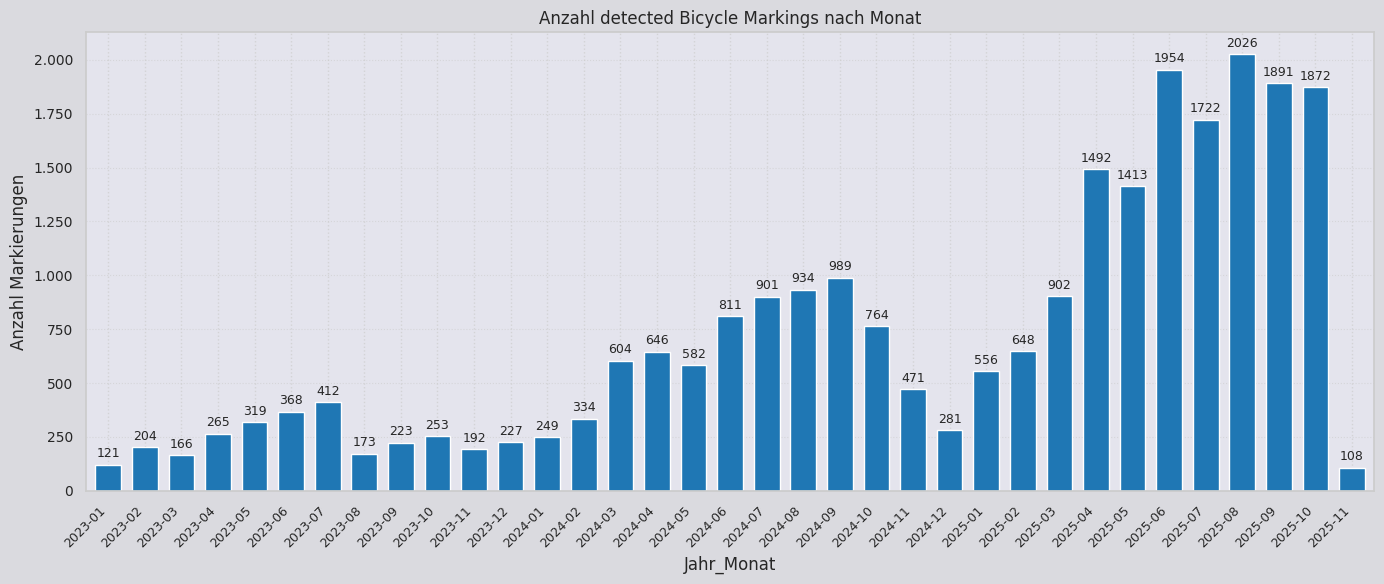

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

df = mapillary_mf_points_cw.copy()
df["month"] = pd.to_datetime(df["last_seen_at"]).dt.to_period("M").dt.to_timestamp()

# Count by month
counts_by_month = df.groupby("month").size()

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 6))
counts_by_month.plot(kind="bar", ax=ax, color="#1f77b4", width=0.7)

# Achsen & Layout
ax.set_xticklabels([d.strftime("%Y-%m") for d in counts_by_month.index], rotation=45, ha="right")
ax.tick_params(axis="x", labelsize=9)

# keine wissenschaftliche Notation
ax.ticklabel_format(style='plain', axis='y')
# Tausenderpunkt (deutsches Schema)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.tick_params(axis="y", labelsize=10)

ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

ax.set_xlabel("Jahr_Monat")
ax.set_ylabel("Anzahl Markierungen")
ax.set_title("Anzahl detected Bicycle Markings nach Monat")

# Totals über Balken
for i, (month, total) in enumerate(counts_by_month.items()):
    if total > 0:
        ax.text(i, total + max(counts_by_month)*0.01, str(int(total)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("mk_output/markings_by_month.svg", bbox_inches="tight")
plt.show()


In [68]:
dates

['2025-11-16']

### create readme file

In [69]:
from datetime import datetime
import pandas as pd

# Hole das Dataset-Datum aus den Parquet-Filenames (Fallback: heute)
if dates:
    try:
        parsed_dates = sorted(pd.to_datetime(dates))
        last_date = parsed_dates[-1].strftime("%Y-%m-%d")
        first_date = parsed_dates[0].strftime("%Y-%m-%d")
    except Exception:
        last_date = datetime.now().strftime("%Y-%m-%d")
        first_date = "N/A"
else:
    last_date = datetime.now().strftime("%Y-%m-%d")
    first_date = "N/A"

# Einfache Statistiken
total_count = len(mapillary_mf_points_cw)
date_range = f"{mapillary_mf_points_cw['first_seen_at'].min()} - {mapillary_mf_points_cw['last_seen_at'].max()}"

# === README-Text ===
readme_content = f"""
# Bicycle Marking Detections Output

This folder contains the output file for detected bicycle markings from Mapillary.  
The output has been created on **{last_date}**.

## Overview

- **Total detections**: {total_count}
- **Data source dates**: {first_date}
- **Detection period**: {date_range}
- **Marking type**: Lane marking - symbol (bicycle)

## Applied Filters

- Only detections with **2+ observations** (min. 180 days apart)
- Only detections seen after **2023-01-01**
- Restricted to **Germany** boundaries

## Output Files

- `mapillary_markings_bicycle_latest.geojson.gz` - Compressed GeoJSON with all markings
- `markings_by_month.svg` - Detection frequency over time

## Statistics Plot

![Anzahl pro Monat](markings_by_month.svg)
"""

# === Datei schreiben ===
with open("mk_output/README.md", "w", encoding="utf-8") as readme_file:
    readme_file.write(readme_content)

print("✅ README.md erfolgreich erstellt!")

✅ README.md erfolgreich erstellt!
